In [ ]:
import os
import json
from PIL import Image



def convert_to_coco(images_dir, labels_dir, class_names, output_json):
    coco_output = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Add categories info
    for i, cls_name in enumerate(class_names):
        coco_output["categories"].append({
            "id": i + 1,
            "name": cls_name,
            "supercategory": "none"
        })

    annotation_id = 1

    for img_id, img_filename in enumerate(os.listdir(images_dir), 1):
        if not img_filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue

        # Load image to get width and height
        img_path = os.path.join(images_dir, img_filename)
        img = Image.open(img_path)
        width, height = img.size

        # Add image info
        coco_output["images"].append({
            "id": img_id,
            "file_name": img_filename,
            "width": width,
            "height": height
        })

        # Corresponding label file
        label_filename = os.path.splitext(img_filename)[0] + '.txt'
        label_path = os.path.join(labels_dir, label_filename)

        if not os.path.exists(label_path):
            continue  # No labels for this image

        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                class_id = int(parts[0]) + 1  # COCO category id starts at 1
                x_min = float(parts[1])
                y_min = float(parts[2])
                x_max = float(parts[3])
                y_max = float(parts[4])

                bbox_width = x_max - x_min
                bbox_height = y_max - y_min

                coco_output["annotations"].append({
                    "id": annotation_id,
                    "image_id": img_id,
                    "category_id": class_id,
                    "bbox": [x_min, y_min, bbox_width, bbox_height],
                    "area": bbox_width * bbox_height,
                    "iscrowd": 0
                })

                annotation_id += 1

    # Save to JSON file
    with open(output_json, 'w') as out_file:
        json.dump(coco_output, out_file, indent=4)

    print(f"Saved COCO annotations to {output_json}")


In [18]:
images_dir = '../dataset/images/test/grayscale_wholeImage'
labels_dir = '../dataset/labels/test/boundingBoxes_wholeImage'
class_names = ['infant seat', 'child seat', 'person', 'everyday object']
output_json = 'transformer_dataset/annotations/instances_test.json'


convert_to_coco(images_dir, labels_dir, class_names, output_json)

Saved COCO annotations to transformer_dataset/annotations/instances_test.json


In [ ]:
!python mmdetection/tools/train.py mmdetection/configs/swin/retinanet_swin-t-p4-w7_fpn_1x_coco.py --work-dir work_dirs/final1

Loads checkpoint by local backend from path: work_dirs/final1/epoch_50.pth


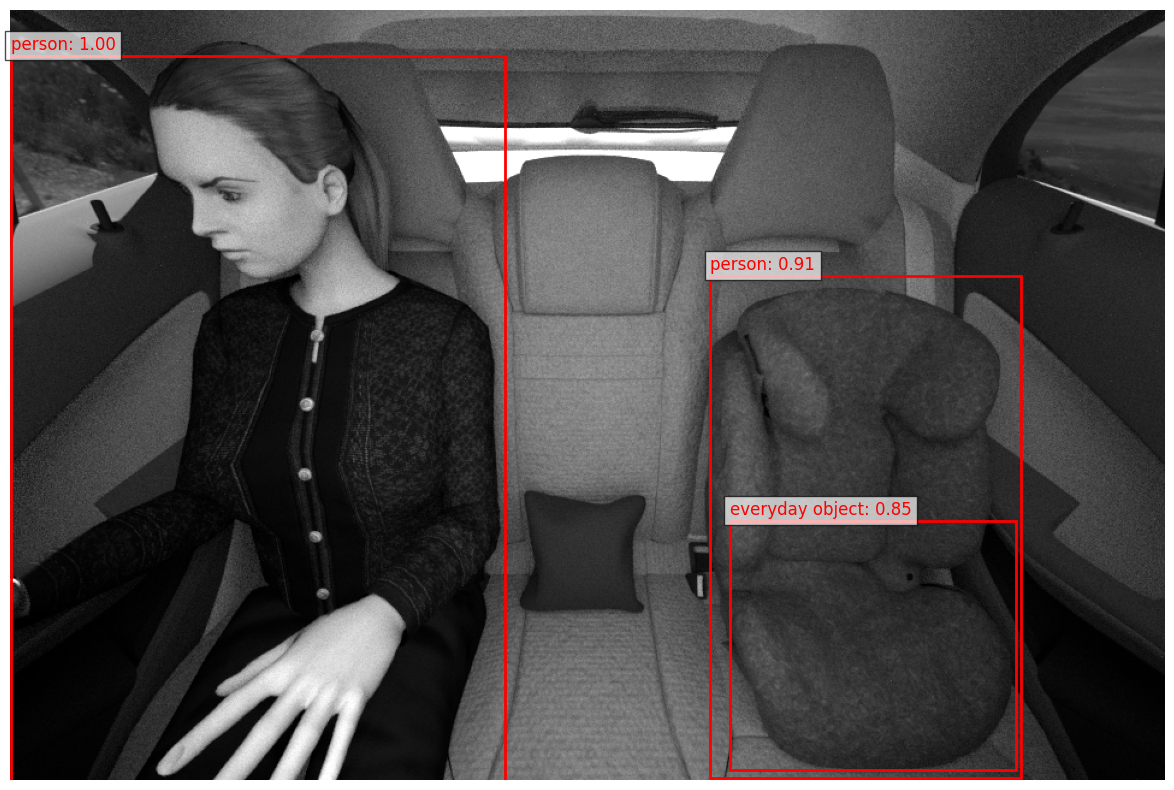


Detections for class 'person':
  Detection 1: confidence=1.00, bbox=[0.0, 37.9, 411.2, 645.5]
  Detection 2: confidence=0.91, bbox=[581.7, 220.6, 839.7, 638.2]

Detections for class 'everyday object':
  Detection 1: confidence=0.85, bbox=[597.8, 424.4, 835.9, 631.2]


In [ ]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

config_file = 'mmdetection/configs/swin/retinanet_swin-t-p4-w7_fpn_1x_coco.py' 
checkpoint_file = 'work_dirs/final2/epoch_50.pth'
device = 'cuda:0'

model = init_detector(config_file, checkpoint_file, device=device)

class_names = ['infant seat', 'child seat', 'person', 'everyday object']

img = 'transformer_dataset/test/grayscale_wholeImage/aclass_test_imageID_108_GT_3_4_6.png'

result = inference_detector(model, img)

# Visualize results 
def visualize_detection(img_path, result, score_threshold=0.3):
    img = mmcv.imread(img_path)
    img = mmcv.bgr2rgb(img)
    
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    
    # Access predictions from the DetDataSample object
    pred_instances = result.pred_instances
    
    # Get bounding boxes, scores, and labels
    bboxes = pred_instances.bboxes.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    
    # Draw detections
    for i in range(len(bboxes)):
        if scores[i] >= score_threshold:
            bbox = bboxes[i]
            label = labels[i]
            score = scores[i]
            
            # Create a rectangle patch
            x1, y1, x2, y2 = bbox
            width = x2 - x1
            height = y2 - y1
            rect = Rectangle((x1, y1), width, height, linewidth=2, 
                             edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            
            # Add label
            plt.text(x1, y1-5, f'{class_names[label]}: {score:.2f}', 
                     color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Print detection results
def print_detections(result, score_threshold=0.3):
    # Access predictions
    pred_instances = result.pred_instances
    
    # Get bounding boxes, scores, and labels
    bboxes = pred_instances.bboxes.cpu().numpy()
    scores = pred_instances.scores.cpu().numpy()
    labels = pred_instances.labels.cpu().numpy()
    
    # Create a dictionary to group detections by class
    class_detections = {}
    for i in range(len(bboxes)):
        if scores[i] >= score_threshold:
            label = int(labels[i])
            if label not in class_detections:
                class_detections[label] = []
            class_detections[label].append((bboxes[i], scores[i]))
    
    # Print results for each class
    for class_id in sorted(class_detections.keys()):
        print(f"\nDetections for class '{class_names[class_id]}':")
        for i, (bbox, score) in enumerate(class_detections[class_id]):
            x1, y1, x2, y2 = bbox
            print(f"  Detection {i+1}: confidence={score:.2f}, bbox=[{x1:.1f}, {y1:.1f}, {x2:.1f}, {y2:.1f}]")

# Call the visualization function
visualize_detection(img, result, score_threshold=0.6)

# Print detection details
print_detections(result, score_threshold=0.6)

In [ ]:
!cd mmdetection && python tools/test.py configs/swin/retinanet_swin-t-p4-w7_fpn_1x_coco.py \
    ../work_dirs/final1/epoch_50.pth \
     --cfg-options test_evaluator.metric="bbox"  --out /home/abdulbari/uni/seminar/swin_transformer/work_dirs/result.pkl

/home/abdulbari/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/optim/optimizer/zero_optimizer.py:11: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import \
05/22 23:25:50 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.20 (default, Oct  3 2024, 15:24:27) [GCC 11.2.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 1752943370
    GPU 0: NVIDIA GeForce RTX 3060
    CUDA_HOME: /usr/local/cuda-12.3
    NVCC: Cuda compilation tools, release 12.3, V12.3.107
    GCC: gcc (Ubuntu 13.3.0-6ubuntu2~24.04) 13.3.0
    PyTorch: 2.4.1+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 2022080

Loading scalars data...
Loaded 110 data points from work_dirs/final1/20250521_161717/vis_data/scalars.json
Organizing metrics...
Available metrics:

TRAIN:
  - lr (100 points)
  - grad_norm (100 points)
  - loss (100 points)
  - loss_cls (100 points)
  - loss_bbox (100 points)

VAL:
  - coco/bbox_mAP (10 points)
  - coco/bbox_mAP_50 (10 points)
  - coco/bbox_mAP_75 (10 points)
  - coco/bbox_mAP_l (10 points)

Generating plots...


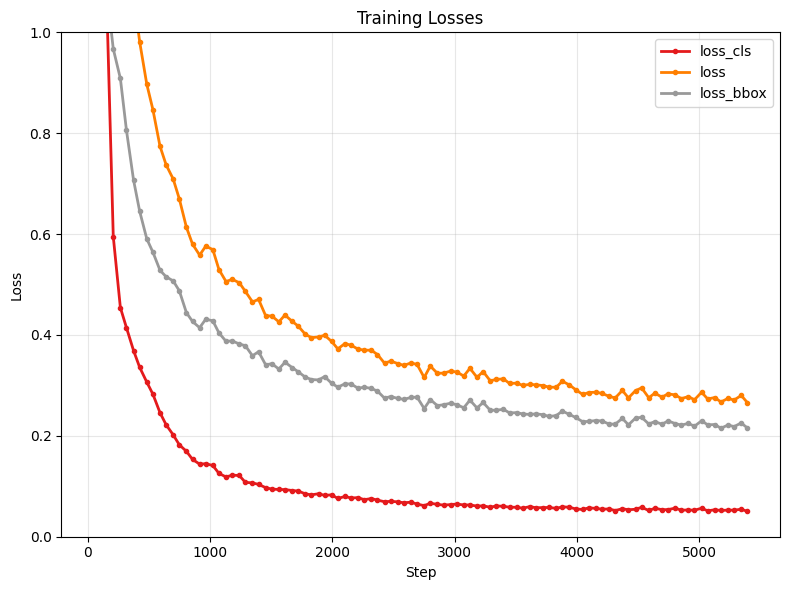

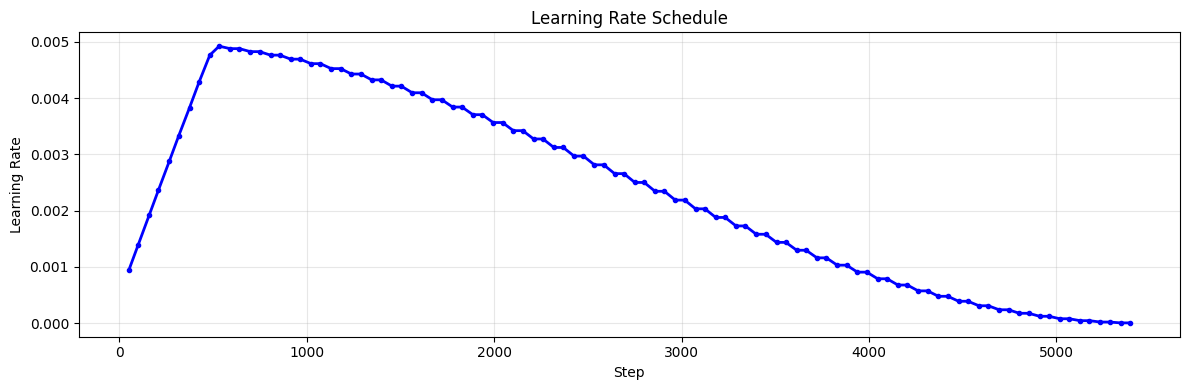

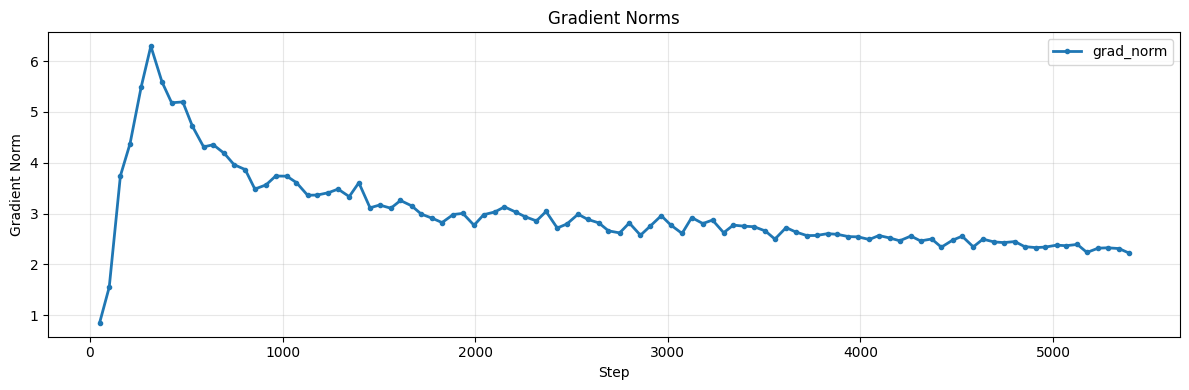

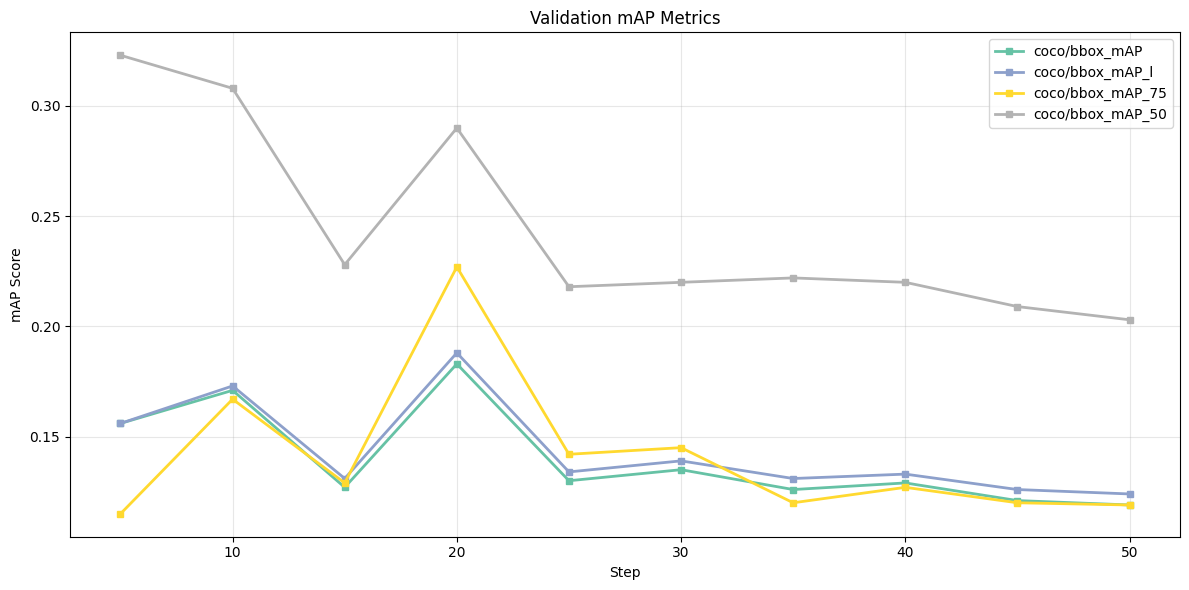

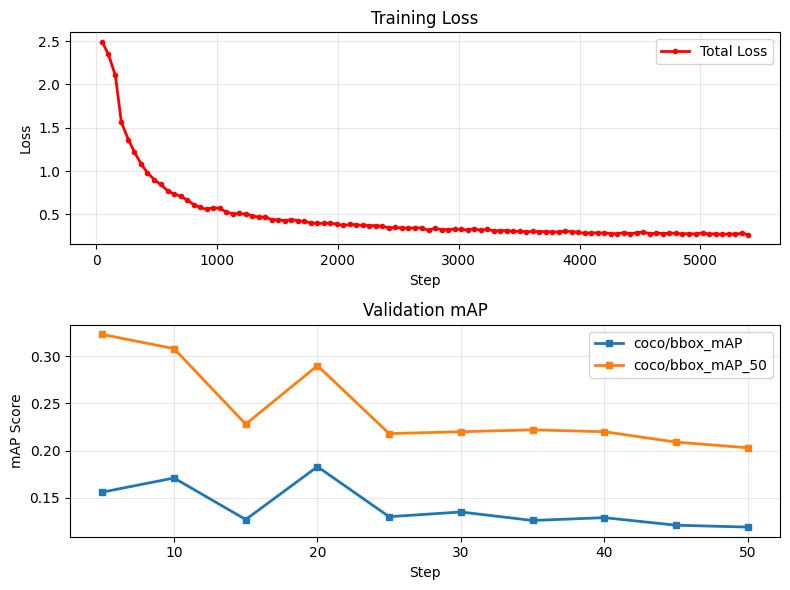

Plots saved and displayed!


In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os

def load_scalars_json(file_path):
    """Load and parse scalars.json file (handles both JSON and JSONL formats)"""
    data = []
    
    with open(file_path, 'r') as f:
        content = f.read().strip()
        
        # Try to parse as regular JSON first
        try:
            data = json.loads(content)
            if not isinstance(data, list):
                data = [data]  # Wrap single object in list
        except json.JSONDecodeError:
            # If that fails, try parsing as JSONL (one JSON object per line)
            for line_num, line in enumerate(content.split('\n'), 1):
                line = line.strip()
                if line:  # Skip empty lines
                    try:
                        data.append(json.loads(line))
                    except json.JSONDecodeError as e:
                        print(f"Warning: Could not parse line {line_num}: {line}")
                        print(f"Error: {e}")
                        continue
    
    print(f"Loaded {len(data)} data points from {file_path}")
    return data

def organize_metrics(data):
    """Organize metrics by type (train/val) and metric name"""
    metrics = defaultdict(lambda: defaultdict(list))
    
    for entry in data:
        if not isinstance(entry, dict):
            continue
            
        step = entry.get('step', 0)
        
        # Process each key-value pair in the entry
        for key, value in entry.items():
            if key in ['step', 'iter', 'epoch', 'time', 'data_time', 'memory']:
                continue  # Skip metadata fields
            
            # Determine if it's training or validation metric
            if key.startswith('coco/') or 'mAP' in key:
                split = 'val'
                clean_name = key
            else:
                split = 'train'
                clean_name = key
            
            # Skip invalid values
            if value == -1.0 or value is None:
                continue
                
            metrics[split][clean_name].append((step, value))
    
    # Sort by step for each metric
    for split in metrics:
        for metric in metrics[split]:
            metrics[split][metric].sort(key=lambda x: x[0])
    
    return metrics

def plot_metrics(metrics, save_dir='plots'):
    """Create plots for all metrics"""
    os.makedirs(save_dir, exist_ok=True)
    
    # Get all unique metric names across splits
    all_train_metrics = set(metrics.get('train', {}).keys())
    all_val_metrics = set(metrics.get('val', {}).keys())
    
    # Categorize metrics
    loss_metrics = [m for m in all_train_metrics if 'loss' in m.lower()]
    lr_metrics = [m for m in all_train_metrics if m == 'lr']
    grad_metrics = [m for m in all_train_metrics if 'grad' in m.lower()]
    map_metrics = [m for m in all_val_metrics if 'mAP' in m or 'map' in m.lower()]
    other_train = [m for m in all_train_metrics if m not in loss_metrics + lr_metrics + grad_metrics]
    
    # Plot losses
    if loss_metrics:
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = plt.cm.Set1(np.linspace(0, 1, len(loss_metrics)))
        
        for i, metric in enumerate(loss_metrics):
            if metric in metrics['train']:
                steps, values = zip(*metrics['train'][metric])
                ax.plot(steps, values, label=metric, color=colors[i], marker='o', markersize=3, linewidth=2)
        
        ax.set_xlabel('Step')
        ax.set_ylabel('Loss')
        ax.set_ylim(0, 1)
        ax.set_title('Training Losses')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}/training_losses.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot learning rate
    if lr_metrics and 'lr' in metrics['train']:
        fig, ax = plt.subplots(figsize=(12, 4))
        steps, values = zip(*metrics['train']['lr'])
        ax.plot(steps, values, color='blue', marker='o', markersize=3, linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel('Learning Rate')
        ax.set_title('Learning Rate Schedule')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}/learning_rate.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot gradient norm
    if grad_metrics:
        fig, ax = plt.subplots(figsize=(12, 4))
        for metric in grad_metrics:
            if metric in metrics['train']:
                steps, values = zip(*metrics['train'][metric])
                ax.plot(steps, values, label=metric, marker='o', markersize=3, linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel('Gradient Norm')
        ax.set_title('Gradient Norms')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}/gradient_norms.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Plot mAP metrics
    if map_metrics:
        fig, ax = plt.subplots(figsize=(12, 6))
        colors = plt.cm.Set2(np.linspace(0, 1, len(map_metrics)))
        
        for i, metric in enumerate(map_metrics):
            if metric in metrics['val']:
                steps, values = zip(*metrics['val'][metric])
                ax.plot(steps, values, label=metric, color=colors[i], marker='s', markersize=5, linewidth=2)
        
        ax.set_xlabel('Step')
        ax.set_ylabel('mAP Score')
        ax.set_title('Validation mAP Metrics')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{save_dir}/validation_map.png', dpi=300, bbox_inches='tight')
        plt.show()
    
    # Combined loss and mAP plot
    if loss_metrics and map_metrics:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
        
        # Plot total loss
        if 'loss' in metrics['train']:
            steps, values = zip(*metrics['train']['loss'])
            ax1.plot(steps, values, color='red', marker='o', markersize=3, linewidth=2, label='Total Loss')
            ax1.set_xlabel('Step')
            ax1.set_ylabel('Loss')
            ax1.set_ylim(0, 1)
            ax1.set_title('Training Loss')
            ax1.grid(True, alpha=0.3)
            ax1.legend()
        
        # Plot main mAP
        main_map_metrics = ['coco/bbox_mAP', 'coco/bbox_mAP_50'] if 'coco/bbox_mAP' in metrics['val'] else list(map_metrics)[:2]
        for metric in main_map_metrics:
            if metric in metrics['val']:
                steps, values = zip(*metrics['val'][metric])
                ax2.plot(steps, values, marker='s', markersize=5, linewidth=2, label=metric)
        
        ax2.set_xlabel('Step')
        ax2.set_ylabel('mAP Score')
        ax2.set_title('Validation mAP')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'{save_dir}/training_overview.png', dpi=300, bbox_inches='tight')
        plt.show()

def main():
    # Update this path to your scalars.json file
    json_file = 'work_dirs/final1/20250521_161717/vis_data/scalars.json'  # or 'path/to/your/scalars.json'
    
    print("Loading scalars data...")
    data = load_scalars_json(json_file)
    
    print("Organizing metrics...")
    metrics = organize_metrics(data)
    
    print("Available metrics:")
    for split in metrics:
        print(f"\n{split.upper()}:")
        for metric in metrics[split]:
            print(f"  - {metric} ({len(metrics[split][metric])} points)")
    
    print("\nGenerating plots...")
    plot_metrics(metrics)
    print("Plots saved and displayed!")

if __name__ == "__main__":
    main()
